# GNN Inference time

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

1. We load the inference times: gpu, cpu and our approach

In [2]:
results = glob.glob("code/results/cpu/*") + glob.glob("code/results/gpu/*") + glob.glob("code/results/ease/*")
results_df = pd.concat([pd.read_csv(result) for result in results])[["graph_name", "device", "time"]].groupby(["graph_name", "device"], as_index=False).mean()

 2. Load file containing the partitioning time of the slowest partitioner. Inference time of -1 means that we run out of gpu memory. 

In [3]:
inference_limit = pd.read_csv("code/data/inference_limit.csv")
overview = results_df.merge(inference_limit, on="graph_name")[["graph_name", "device", "time", "time_slowest_partitioner"]]
overview = overview.rename(columns={"time": "inference_time"})

markdown = overview.copy()
markdown = markdown.sort_values(by=["graph_name", "inference_time"])
markdown = markdown.rename(columns={"graph_name": "Graph", "device": "Device", "inference_time": "Inference time (seconds)", "time_slowest_partitioner": "Slowest Partitioner Time (seconds)" })
markdown = markdown.round(3)
markdown = markdown.replace({-1: "Out-of-memory"})
markdown = markdown.replace({"cpu": "CPU", "cuda": "GPU", "ease": "EASE"})
print(markdown.sort_values(by=["Graph"]).to_markdown())

overview.sort_values(by=["graph_name"])

|    | Graph                      | Device   | Inference time (seconds)   |   Slowest Partitioner Time (seconds) |
|---:|:---------------------------|:---------|:---------------------------|-------------------------------------:|
|  2 | com-orkut.ungraph          | EASE     | 0.301                      |                               54.986 |
|  1 | com-orkut.ungraph          | GPU      | 11.165                     |                               54.986 |
|  0 | com-orkut.ungraph          | CPU      | 621.256                    |                               54.986 |
|  5 | enwiki-2021                | EASE     | 0.562                      |                               68.339 |
|  4 | enwiki-2021                | GPU      | 12.15                      |                               68.339 |
|  3 | enwiki-2021                | CPU      | 789.098                    |                               68.339 |
|  7 | eu-2015-host               | GPU      | Out-of-memory              |     

,graph_name,device,inference_time,time_slowest_partitioner
0,com-orkut.ungraph,cpu,621.256233,54.985525
1,com-orkut.ungraph,cuda,11.165484,54.985525
2,com-orkut.ungraph,ease,0.300822,54.985525
3,enwiki-2021,cpu,789.098189,68.338633
4,enwiki-2021,cuda,12.149714,68.338633
5,enwiki-2021,ease,0.561780,68.338633
6,eu-2015-host,cpu,2013.244729,107.197725
7,eu-2015-host,cuda,-1.000000,107.197725
8,eu-2015-host,ease,0.859061,107.197725
11,eu-2015-tpd,ease,0.501242,57.907909


We compare the inference time on the cpu with slowest partitioner. 

In [4]:
cpu_factor = overview.copy()
cpu_factor = cpu_factor[cpu_factor.device == "cpu"]
cpu_factor["factor"] = cpu_factor["inference_time"] / cpu_factor["time_slowest_partitioner"]
print("Factor is between", cpu_factor["factor"].min(),"and", cpu_factor["factor"].max() )

Factor is between 9.00076146954034 and 19.350922796093798


# Plot
- y-axis has a logarithmic scale
- OOM means out of GPU memory
- GPU == Nvidia RTX8000, because the smaller GPUS runs out of memory, as reported in the paper. 

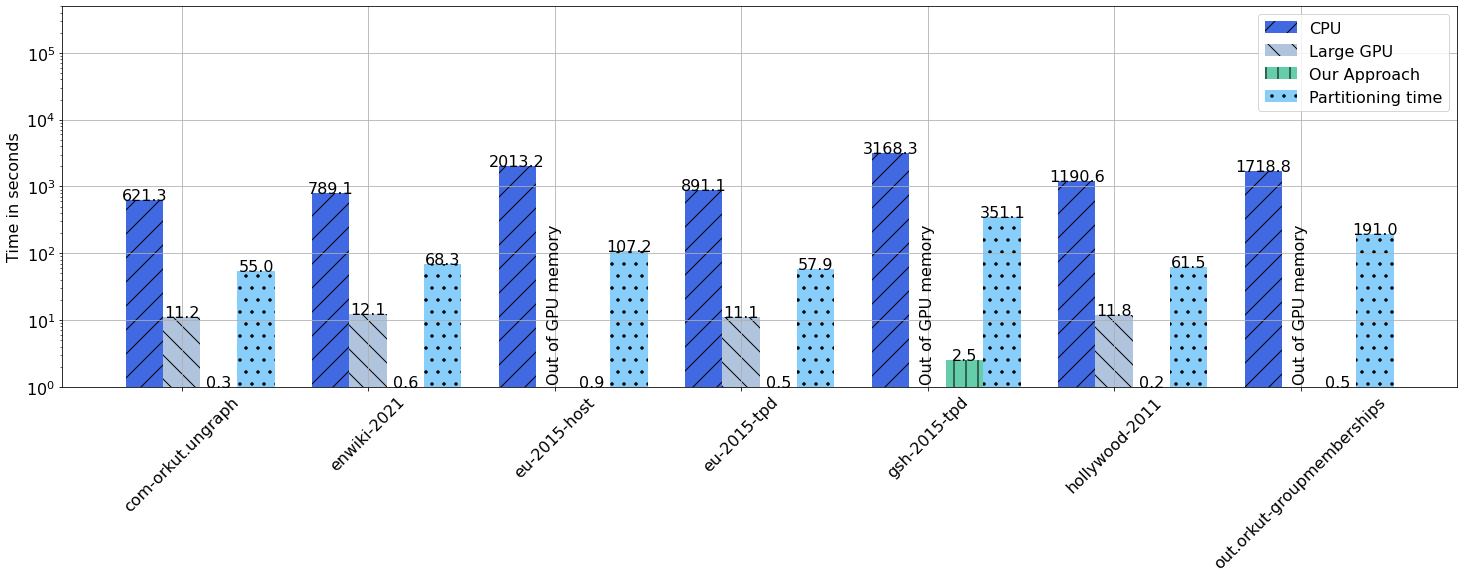

In [7]:
plt.rcParams["figure.figsize"] = (25,7)
plt.rcParams.update({'font.size': 16})
cpus = np.around(overview[overview.device == "cpu"].sort_values(by=["graph_name"])["inference_time"].to_numpy(), 1)
gpus = np.around(overview[overview.device == "cuda"].sort_values(by=["graph_name"])["inference_time"].to_numpy(), 1)
ease = np.around(overview[overview.device == "ease"].sort_values(by=["graph_name"])["inference_time"].to_numpy(), 1)
part_time = np.around(overview[overview.device == "ease"].sort_values(by=["graph_name"])["time_slowest_partitioner"].to_numpy(), 1)
graphs =  overview[overview.device == "ease"].sort_values(by=["graph_name"])["graph_name"].to_numpy()

x_positions = np.arange(len(graphs)) 
bar_width = 0.2
y_min = 1

fig, ax = plt.subplots()
#fig.tight_layout()
plt.grid()
ax.set_yscale('log') 
ax.set_ylim(y_min, 500000)
    
rects1 = ax.bar(x_positions - bar_width, cpus, bar_width, label="CPU", hatch="/",color="royalblue")
rects2 = ax.bar(x_positions, gpus, bar_width, label="Large GPU", hatch="\\", color="lightsteelblue" )
rects3 = ax.bar(x_positions + bar_width, ease, bar_width, label="Our Approach", hatch="|",color="mediumaquamarine" )
rects4 = ax.bar(x_positions + 2* bar_width, part_time, bar_width, label="Partitioning time", hatch=".",color="lightskyblue" )

ax.set_ylabel('Time in seconds')
ax.set_xticks(x_positions, graphs)
ax.legend()

lim = ax.get_ylim()[0]

for x, values in enumerate([cpus, gpus, ease,part_time]):
    for v in range(len(values)):
        # We set the time to a negative value if we run out of memory
        if values[v] < 0:
          ax.text(x = v + (x-1) * bar_width, 
            y = lim +0.2, # the postition where we write OOM
            s = "Out of GPU memory", 
            horizontalalignment='center',
            # bbox=dict(facecolor='red', alpha=0.5),
            rotation=90
          )
        else:
            # find the position where we write the label / text above the bars
            y = lim
            if values[v] >= lim:
                y = values[v]
            ax.text(x = v + (x-1) * bar_width, 
              y = y,  # the postition where we write the inference time
              s =str(values[v]),
              horizontalalignment='center',
              #bbox=dict(facecolor='red', alpha=0.1)
            )

#plt.title("Inference time on test graphs (Table IV) on a CPU, GPU (RTX8000), our approach and partitioner with highest run-time.")
plt.xticks(rotation=45)
#plt.show()
#fig.tight_layout() 
plt.savefig("figures/inference.pdf")

fig.savefig("figures/inference.png",dpi=300, bbox_inches="tight",transparent=True)


